In [9]:
# standard libraries

import datetime
import math
import pathlib
import sqlite3
import sys

# installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import spiceypy

# append to root directory this repo
sys.path.append("../")

# auxiliary module
from auxiliary import photometry

In [10]:
# Access the NEO database

database_dir = pathlib.Path("../databases/neos/")
database_file = pathlib.Path("neodys.db")
database_filepath = database_dir / database_file

# establish a connection to the database with a cursor
neodys_db_con = sqlite3.connect(database_filepath)
neodys_db_cur = neodys_db_con.cursor()


In [11]:
# dataframe

neo_df = pd.read_sql("SELECT * FROM main", neodys_db_con)
neodys_db_con.close()

In [12]:
neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,Aphel_AU,Perihel_AU,NEOClass
0,433,60000.0,1.458129,0.222782,10.827822,304.287024,178.926986,110.777664,10.91,0.46,1.782974,1.133284,Amor
1,719,60600.0,2.636157,0.546780,11.575260,183.857164,156.215517,148.450677,15.54,0.15,4.077554,1.194760,Amor
2,887,60600.0,2.472525,0.571093,9.398798,110.423047,350.474210,340.198429,13.40,-0.12,3.884567,1.060483,Amor
3,1036,60600.0,2.665299,0.532826,26.686737,215.494963,132.496161,6.984965,9.46,0.30,4.085439,1.245159,Amor
4,1221,60600.0,1.920154,0.434718,11.868483,171.260808,26.717609,271.700797,17.42,0.15,2.754880,1.085428,Amor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35858,2024SZ1,60600.0,1.560467,0.666940,5.839193,179.862282,293.754200,340.258647,24.94,0.15,2.601204,0.519729,Apollo
35859,2024SZ2,60600.0,1.330991,0.226167,25.856581,2.786025,12.898806,5.884706,25.89,0.15,1.632016,1.029965,Amor
35860,6344P-L,60600.0,2.821108,0.661803,4.678521,182.791071,235.006174,213.375870,20.40,0.15,4.688125,0.954091,Apollo
35861,2024SB3,60600.0,2.117875,0.641717,0.273983,325.125940,328.074041,21.566756,25.58,0.15,3.476952,0.758798,Apollo


In [13]:
# kernels

# lsk - leapseconds kernel
spiceypy.furnsh("/home/astavak/python/kernels/lsk/naif0012.tls")

# barycenter bsp 1549 DEC 31 --- 2650 JAN 25
spiceypy.furnsh("/home/astavak/python/kernels/spk/de440s.bsp")

# pck - "GM" (gravitational constant times mass)
spiceypy.furnsh("/home/astavak/python/kernels/pck/gm_de440.tpc")

# constant gravitational parameter of Sun (bodvcd: body-vector-constant)
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item="GM", maxn=1)
print(gm_sun_pre)

gm_sun = gm_sun_pre[0]

[1.3271244e+11]


In [14]:
help(spiceypy.bodvcd)

Help on function bodvcd in module spiceypy.spiceypy:

bodvcd(bodyid: int, item: str, maxn: int) -> Tuple[int, numpy.ndarray]
    Fetch from the kernel pool the double precision values of an item
    associated with a body, where the body is specified by an integer ID
    code.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/bodvcd_c.html

    :param bodyid: Body ID code.
    :param item:
                Item for which values are desired,
                ("RADII", "NUT_PREC_ANGLES", etc.)
    :param maxn: Maximum number of values that may be returned.
    :return: dim, values



In [15]:
# determine today's datetime at midnight Julian Date

curr_time_et = spiceypy.utc2et(datetime.datetime.now().strftime("%Y-%m-%d"))
print(curr_time_et)

781099269.1823455


In [16]:
# position vector
sun2earth_position_vec = spiceypy.spkgps(targ=399,
                                        et=curr_time_et,
                                        ref="ECLIPJ2000",
                                        obs=10)[0]

sun2earth_position_vec

array([ 1.47915192e+08,  2.33008126e+07, -2.19649540e+03])

In [17]:
# AU -> kms and deg -> rad. Later used for apparent magnitude and position vector

neo_df.loc[:, "Perihel_km"] = neo_df["Perihel_AU"].apply(lambda x: abs(spiceypy.convrt(x, "AU", "km")))
neo_df.loc[:, "Incl_rad"] = neo_df["Incl_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "LongAscNode_rad"] = neo_df["LongAscNode_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "ArgP_rad"] = neo_df["ArgP_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "MeanAnom_rad"] = neo_df["MeanAnom_deg"].apply(lambda x: math.radians(x))
neo_df.loc[:, "Epoch_JD"] = neo_df["Epoch_MJD"].apply(lambda x: x + 2400000.5)
neo_df.loc[:, "Epoch_et"] = neo_df["Epoch_JD"].apply(lambda x: spiceypy.utc2et(str(x) + "JD"))

In [18]:
help(spiceypy.conics)

Help on function conics in module spiceypy.spiceypy:

conics(elts: numpy.ndarray, et: float) -> numpy.ndarray
    Determine the state (position, velocity) of an orbiting body
    from a set of elliptic, hyperbolic, or parabolic orbital
    elements.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/conics_c.html

    :param elts: Conic elements.
    :param et: Input time.
    :return: State of orbiting body at et.



In [19]:
neo_df.loc[:, "sun2neo_position_vec"] = \
    neo_df.apply(lambda x: spiceypy.conics(elts=[x["Perihel_km"],
                                                    x["Ecc_"],
                                                    x["Incl_rad"],
                                                    x["LongAscNode_rad"],
                                                    x["ArgP_rad"],
                                                    x["MeanAnom_rad"],
                                                    x["Epoch_et"],
                                                    gm_sun],
                                                    et=curr_time_et)[:3],
                                                    axis=1)
print(neo_df["sun2neo_position_vec"][0])

[-1.46024207e+08 -1.58184408e+08 -4.01195131e+07]


We can verify the value from https://ssd.jpl.nasa.gov/horizons/app.html#/ 

:type: vector table

:cordinate center: Solar System Barycenter (SSB)


In [20]:
# Computing apparent magnitudes, we need to re-compute the positional vector and convert back to AU
neo_df.loc[:, "neo2earth_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: sun2earth_position_vec - x)

print(neo_df["neo2earth_position_vec"][0])

neo_df.loc[:, "neo2sun_position_vec"] = \
    neo_df["sun2neo_position_vec"].apply(lambda x: -1.0 * x)


# spicecypy supports vectorised operation -- (if not the for loop solution)
neo_df.loc[:, "neo2earth_position_vec_AU"] = \
    neo_df["neo2earth_position_vec"].apply(lambda x: spiceypy.convrt(x, "km", "AU"))

print(neo_df["neo2earth_position_vec_AU"][0])

neo_df.loc[:, "neo2sun_position_vec_AU"] = \
    neo_df["neo2sun_position_vec"].apply(lambda x: spiceypy.convrt(x, "km", "AU"))

print(neo_df["neo2sun_position_vec_AU"][0])

[2.93939399e+08 1.81485220e+08 4.01173166e+07]
[1.96486352 1.21315377 0.2681677 ]
[0.97611154 1.05739746 0.26818238]


In [21]:
neo_df.loc[:, "app_mag"] = neo_df.apply(lambda x: photometry.hg_app_mag(abs_mag=x["AbsMag_"],
                                                                        vec_obj2obs=x["neo2earth_position_vec_AU"],
                                                                        vec_obj2ill=x["neo2sun_position_vec_AU"],
                                                                        slope_g=x["SlopeParamG_"]), axis=1)

In [22]:
neo_df[["Name", "AbsMag_", "app_mag"]].sort_values(by="app_mag")

,Name,AbsMag_,app_mag
7582,2010LB67,0.17,1.922326
7589,2010LF64,0.17,2.055760
3,1036,9.46,9.284086
80,4954,12.59,11.139312
313,66146,14.45,13.630986
...,...,...,...
21684,2019XP1,25.05,46.982616
18271,2018KC4,26.26,47.343110
3273,688841,18.79,48.121267
25844,2021JE1,26.70,50.235560


In [23]:
neos_2_del = ["2010LB67", "2010LF64"]
neo_df = neo_df[~neo_df["Name"].isin(neos_2_del)].copy()

neo_df.reset_index(drop=True, inplace=True)

neo_df

,Name,Epoch_MJD,SemMajAxis_AU,Ecc_,Incl_deg,LongAscNode_deg,ArgP_deg,MeanAnom_deg,AbsMag_,SlopeParamG_,...,ArgP_rad,MeanAnom_rad,Epoch_JD,Epoch_et,sun2neo_position_vec,neo2earth_position_vec,neo2sun_position_vec,neo2earth_position_vec_AU,neo2sun_position_vec_AU,app_mag
0,433,60000.0,1.458129,0.222782,10.827822,304.287024,178.926986,110.777664,10.91,0.46,...,3.122865,1.933435,2460000.5,7.305553e+08,"[-146024207.28686294, -158184407.8405671, -401...","[293939399.1914294, 181485220.48559317, 401173...","[146024207.28686294, 158184407.8405671, 401195...","[1.964863523695989, 1.2131537684399798, 0.2681...","[0.9761115361323939, 1.0573974562047845, 0.268...",14.134404
1,719,60600.0,2.636157,0.546780,11.575260,183.857164,156.215517,148.450677,15.54,0.15,...,2.726475,2.590953,2460600.5,7.823953e+08,"[-500228947.27671385, 310746376.086338, -70395...","[648144139.1812803, -287445563.4413119, 703931...","[500228947.27671385, -310746376.086338, 703953...","[4.332575968644651, -1.9214549128415825, 0.470...","[3.343823981081056, -2.0772112250767782, 0.470...",22.482042
2,887,60600.0,2.472525,0.571093,9.398798,110.423047,350.474210,340.198429,13.40,-0.12,...,6.116929,5.937583,2460600.5,7.823953e+08,"[211284807.06922656, 77714621.93111208, -37263...","[-63369615.164660126, -54413809.286086015, 372...","[-211284807.06922656, -77714621.93111208, 3726...","[-0.4235997137171919, -0.3637338490371995, 0.2...","[-1.4123517012807871, -0.5194901612723948, 0.2...",14.867943
3,1036,60600.0,2.665299,0.532826,26.686737,215.494963,132.496161,6.984965,9.46,0.30,...,2.312494,0.121911,2460600.5,7.823953e+08,"[181616314.28183818, 14984014.894236084, 46874...","[-33701122.37727174, 8316797.750789981, -46876...","[-181616314.28183818, -14984014.894236084, -46...","[-0.22527808877907876, 0.05559435917551728, -0...","[-1.214030076342674, -0.10016195305967797, -0....",9.284086
4,1221,60600.0,1.920154,0.434718,11.868483,171.260808,26.717609,271.700797,17.42,0.15,...,0.466310,4.742073,2460600.5,7.823953e+08,"[166739325.44391805, 291691866.9057493, -65913...","[-18824133.539351612, -268391054.26072326, 659...","[-166739325.44391805, -291691866.9057493, 6591...","[-0.12583156071761037, -1.7940833860783865, 0....","[-1.1145835482812056, -1.9498396983135815, 0.4...",21.717356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35856,2024SZ1,60600.0,1.560467,0.666940,5.839193,179.862282,293.754200,340.258647,24.94,0.15,...,5.126978,5.938634,2460600.5,7.823953e+08,"[155381510.14254558, 22866955.356304325, -2376...","[-7466318.237979144, 433857.28872174025, 23745...","[-155381510.14254558, -22866955.356304325, 237...","[-0.049909254773148774, 0.0029001568467649057,...","[-1.038661242336744, -0.15285615538843036, 0.0...",19.654382
35857,2024SZ2,60600.0,1.330991,0.226167,25.856581,2.786025,12.898806,5.884706,25.89,0.15,...,0.225127,0.102707,2460600.5,7.823953e+08,"[152169902.75522706, 23892684.927654848, 79810...","[-4254710.850660622, -591872.2826287821, -7983...","[-152169902.75522706, -23892684.927654848, -79...","[-0.028440985377710965, -0.0039564218407706605...","[-1.0171929729413063, -0.15971273407596592, -0...",21.980675
35858,6344P-L,60600.0,2.821108,0.661803,4.678521,182.791071,235.006174,213.375870,20.40,0.15,...,4.101632,3.724111,2460600.5,7.823953e+08,"[-278243426.5513352, -626308640.134313, 500859...","[426158618.4559016, 649609452.7793391, -500881...","[278243426.5513352, 626308640.134313, -5008597...","[2.848694414617598, 4.342370985057971, -0.3348...","[1.859942427054003, 4.186614672822776, -0.3348...",27.911006
35859,2024SB3,60600.0,2.117875,0.641717,0.273983,325.125940,328.074041,21.566756,25.58,0.15,...,5.725972,0.376411,2460600.5,7.823953e+08,"[160307083.378146, 28930459.867279403, 551810....","[-12391891.473579556, -5629647.2222533375, -55...","[-160307083.378146, -28930459.867279403, -5518...","[-0.08283467821262987, -0.037631867346500855, ...","[-1.0715866657762252, -0.1933881795816961, -0....",21.372494


In [24]:
# from sqlalchemy import create_engine, BIGINT, Column, Float, Integer, MetaData, Table, Text

# database_dir =  pathlib.Path("../databases/neos/")
# database_file = "new_neo.db"
# database_filepath = database_dir / database_file
# engine = create_engine(f"sqlite:///{database_filepath}")

In [25]:
# metadata = MetaData()

# neo_table = Table(
#     'main', metadata,
#     Column('index', BIGINT),
#     Column('Name', String, primary_key=True),
#     Column('Epoch_MJD', Float),
#     Column('SemMajAxis_AU', Float),
#     Column('Ecc_', Float),
#     Column('Incl_deg', Float),
#     Column('LongAscNode_deg', Float),
#     Column('ArgP_deg', Float),
#     Column('MeanAnom_deg', Float),
#     Column('AbsMag_', Float),
#     Column('SlopeParamG_', Float),
#     Column('Aphel_AU', Float),
#     Column('Perihel_AU', Float),
#     Column('NEOClass', String),
#     Column('Perihel_km', Float),
#     Column('Incl_rad', Float),
#     Column('LongAscNode_rad', Float),
#     Column('ArgP_rad', Float),
#     Column('MeanAnom_rad', Float),
#     Column('Epoch_JD', Float),
#     Column('Epoch_et', Float),
#     Column('sun2neo_position_vec', Text),
#     Column('neo2earth_position_vec', Text),
#     Column('neo2sun_position_vec', Text),
#     Column('neo2earth_position_vec_AU', Text),
#     Column('neo2sun_position_vec_AU', Text),
#     Column('app_mag', Float)
# )

# metadata.create_all(engine)

In [26]:
# neo_df.to_sql('main', con=engine, if_exists='replace', index=False)

In [29]:
help(spiceypy.recrad)

Help on function recrad in module spiceypy.spiceypy:

recrad(rectan: Union[numpy.ndarray, Iterable[float]]) -> Tuple[float, float, float]
    Convert rectangular coordinates to range, right ascension, and declination.

    https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/recrad_c.html

    :param rectan: Rectangular coordinates of a point.
    :return:
            Distance of the point from the origin,
            Right ascension in radians,
            Declination in radians



In [27]:
# Now plot the Sun and its opposition on the ecliptic cordinate system. (measured on March equinox)

curr_time_utc = datetime.datetime.now().strftime("%Y-%m-%d")
# we multiply by "-1" for satisfying the triangle law of vector and measurement instead from sun use Earth
earth2sun_position_vec = -1.0 * sun2earth_position_vec

# rectangular cordinate system to RA and Dec
_, sun_ecl_long, sun_ecl_lat = spiceypy.recrad(earth2sun_position_vec)

# convert the values to determine "Opposition direction" 180 degree in direction and % 360 not to exceed the range
sun_opp_ecl_long = (sun_ecl_long + np.pi) % (2 * np.pi)
sun_opp_ecl_lat = -1.0 * sun_ecl_lat

# transform longitude values for matplotlib betwn -180 to 180 rad.
if sun_ecl_long > np.pi:
    sun_ecl_long_4plot = -1 * ((sun_ecl_long % np.pi) - np.pi)
else:
    sun_ecl_long_4plot = -1 * sun_ecl_long


if sun_opp_ecl_long > np.pi:
    sun_opp_ecl_long_4plot = -1 * ((sun_opp_ecl_long % np.pi) - np.pi)
else:
    sun_opp_ecl_long_4plot = -1 * sun_opp_ecl_long

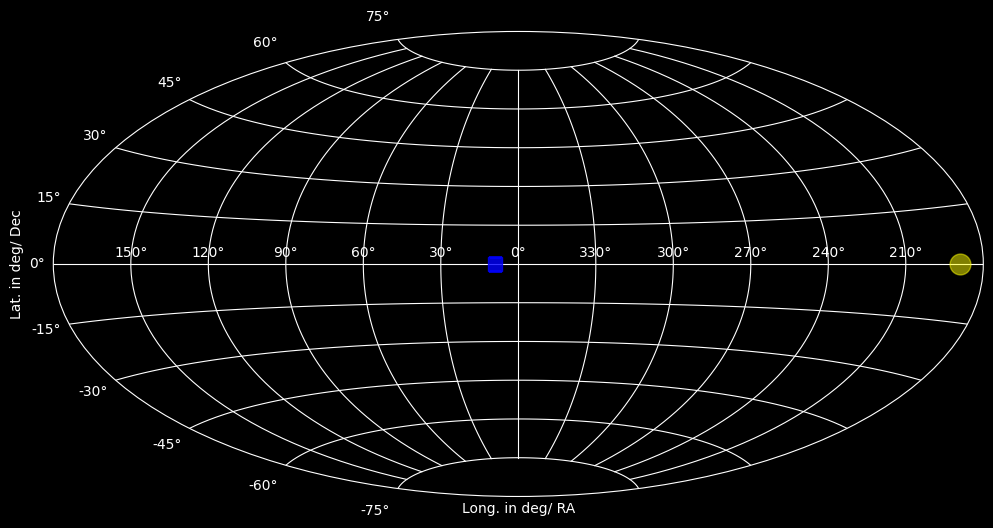

In [28]:
# plotting markers: Sun and the oppostion

# paper format
plt.style.use("dark_background")
plt.figure(figsize=(12,8))

# projection type
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. and latitude (labels)
plt.xlabel("Long. in deg/ RA")
plt.ylabel("Lat. in deg/ Dec")

# ticks with ecliptic cordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# add sun and opposition
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

plt.plot(sun_opp_ecl_long_4plot,
         sun_opp_ecl_lat,
         color="blue",
         marker="s",
         markersize=10,
         alpha=0.8)

plt.show()

In [31]:
# plotting for all the points

# We compute now the NEO's coordiantes in a similar way using the dataframe and the apply function.
neo_df.loc[:, "earth2neo_position_vec_AU"] = \
    neo_df["neo2earth_position_vec_AU"].apply(lambda x: -1.0 * np.array(x))

neo_df.loc[:, "earth2neo_recrad"] = \
    neo_df["earth2neo_position_vec_AU"].apply(lambda x: spiceypy.recrad(x))


# from earth2neo_recrad vals --> 3 output
neo_df.loc[:, "earth2neo_dist_AU"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[0])

neo_df.loc[:, "earth2neo_eclip_long"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[1])

neo_df.loc[:, "earth2neo_eclip_lat"] = \
    neo_df["earth2neo_recrad"].apply(lambda x: x[2])


# conversion required for matplot lib -pi to pi and ivert as value plots from left to right
neo_df.loc[:, "earth2neo_eclip_long_4plot_ecl"] = \
    neo_df["earth2neo_eclip_long"].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

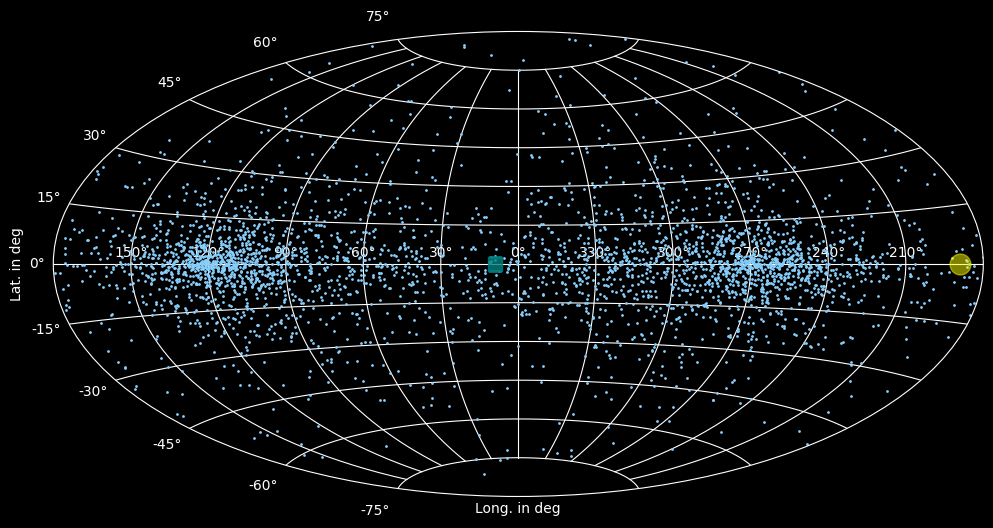

In [33]:
# ipywidgets to be added to play with the dial (app_mag, abs_mag, type, distance)
neo_sub_df = neo_df.loc[(neo_df["app_mag"] > 25) \
                        & (neo_df["AbsMag_"] > 20) \
                        & (neo_df["earth2neo_dist_AU"] < 1)].copy()

# print(neo_sub_df)

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

plt.plot(neo_sub_df["earth2neo_eclip_long_4plot_ecl"], \
         neo_sub_df["earth2neo_eclip_lat"], \
         marker='.', linestyle='None', markersize=2, alpha=1, color="lightskyblue")

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# Add the Sun
plt.plot(sun_ecl_long_4plot,
         sun_ecl_lat,
         color="yellow",
         marker="o",
         markersize=15,
         alpha=0.5)

# Add the Opposition point
plt.plot(sun_opp_ecl_long_4plot,
         sun_opp_ecl_lat,
         color="teal",
         marker="s",
         markersize=10,
         alpha=0.8)

plt.show()

Figure above for based on panstars, sun in yellow and blue dot is the opposition.